# Esercitazione 10

L'obiettivo di questa esercitazione è simulare nuovamente il problema del commesso viaggiatore (TSP) mediante la tecnica del *Simulated Annealing* e facendo uso dell'algoritmo genetico implementato nell'esercitazione precedente parallelizzato su 4 core.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

In [77]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

### Esercizio 10.1

In questa prima parte modifichiamo il codice dell'esercitazione precedente per adattarlo alla tecnica del *Simulated Annealing*.
L'idea alla base è quella di interpretare la funzione di costo (la *fitness* dell'esercitazione precedente) $L(\vec{x}_{1},\vec{x}_{2},...\vec{x}_{N})=L(\vec{X})$ come un'energia per un sistema fisico che molto lentamente si raffredda. Ad esempio possiamo interpretare questo processo come la fase di cristallizzazione di un liquido. Se tale processo avviene in maniera sufficientemente lenta, il cristallo finale non presenta difetti e dunque globalmente si trova al suo minimo di energia.
Qualsiasi problema di ottimizzazione può essere quindi interpretato come un problema di annealing. Se $T$ varia in modo sufficientemente lento, la distribuzione di probabilità secondo la quale il sistema esplora lo spazio delle configurazioni è la distribuzione di Boltzmann:
$$p(x) = \frac{e^{-\beta L(\vec{X})}}{Z}$$
Questa viene campionata usando l'algoritmo di Metropolis. Se dunque la configurazione nuova $\vec{X}_{new}$ è caratterizzata da una fitness più bassa della precedente $\vec{X}_{old}$, essa viene accettata con probabilità di accettazione $\alpha=1$. Al contrario, se la configurazione nuova $\vec{X}_{new}$ è contraddistinta da una fitness più alta della precedente $\vec{X}_{old}$, allora la mossa viene accettata con probabilità:
$$\alpha= e^{-\beta\big[L({\vec{X}_{new})-L(\vec{X}_{old}})\big]}$$

Vogliamo quindi utilizzare una successione discreta di temperature $T$ via via decrescenti (o ugualmente una successione di $\beta$ crescenti) e per ciascuna di esse svolgere un certo numero di mosse $N_{metro}$ con l'algoritmo Metropolis per esplorare al meglio lo spazio delle configurazioni. Se il numero di mosse è sufficientemente alto il processo non dovrebbe stabilizzarsi intorno ad un minimo locale metastabile.
Questo algoritmo dunque dovrebbe portare verso una convergenza il problema del commesso viaggiatore e quindi alla fine della simulazione dovremmo essere in grado di individuare il percorso migliore (*fitness* più bassa).

---
Nelle simulazioni seguenti abbiamo scelto di considerare $\beta\in[0,150]$ e $N_{metro}=3000$ e per ciascun step di evoluzione il nuovo cromosoma $\vec{X}_{new}$ viene generato da $\vec{X}_{old}$ [1] attraverso l'uso di una sola mutazione per step. Questa viene scelta in modo casuale tra le 4 mutazioni disponibili (si veda <font color="red"> Esercitazione 9 </font>).

[1]: Si noti che nell'algoritmo del SA non è necessaria un'intera popolazione di cromosomi, bensì, ne servono solamente due. Uno rappresenta la configurazione attuale e il secondo costituisce la configurazione modificata tramite mutazione del primo.

**A) Percorso lungo una circonferenza**:

Generiamo casualmente le 32 città su una circonferenza di raggio unitario e centrata nell'origine.

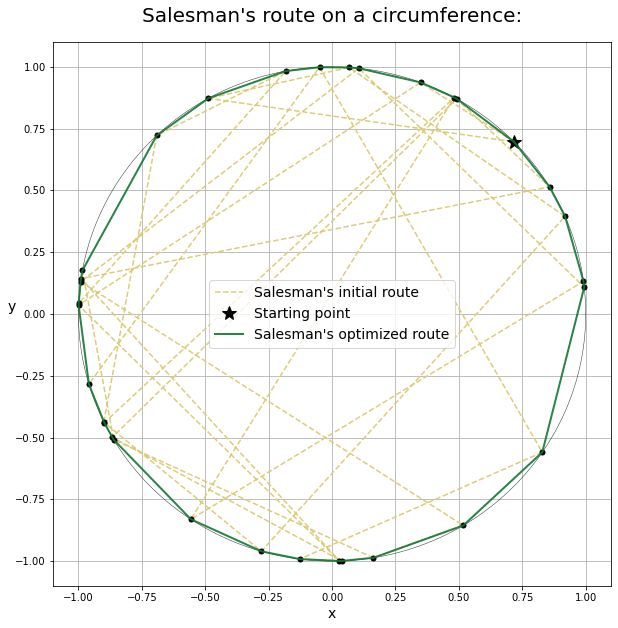

In [4]:
position0 = np.loadtxt('cities_positions.dat')
position00 = np.loadtxt('cities_positions_init.dat')

M=5000                         
np.random.seed(0)     
r = 2*np.pi*np.random.rand(M) 
r.sort()
x_cirle = np.cos(r)
y_cirle = np.sin(r)

plt.figure(figsize=(10,10))
plt.title("Salesman's route on a circumference:", fontsize=20, pad=20)

plt.plot(x_cirle,y_cirle, linestyle ='-', color ='black',alpha=0.8,linewidth=0.5)

#Percorso iniziale:
x0 = position00.T[0]
y0 = position00.T[1]
x0 = np.append(x0,x0[0])
y0 = np.append(y0,y0[0])
plt.plot(x0,y0, label= "Salesman's initial route",color='#DDCC77', linestyle='--',alpha =1)

#Percorso finale:
x = position0.T[0]
y = position0.T[1]
label = position0.T[2]
for i in range(len(position0)):
    plt.plot(x[i], y[i], color='black',marker='.',markersize=10)
    #plt.text(x[i] * (1 + 0.05), y[i] * (1 + 0.05) , int(label[i]) , fontsize=10)
plt.plot(x[0],y[0],'*', markersize=14, label='Starting point',color='black') 
x = np.append(x,x[0])
y = np.append(y,y[0])

plt.plot(x,y, label= "Salesman's optimized route",color='#117733', linewidth=2,alpha=0.9)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',rotation=0,fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)
plt.show()

Dal grafico presentato qui sopra possiamo osservare che, anche utilizzando il *Simulated Annealing*, come per l'esercitazione precedente, il commesso viaggiatore percorre il cammino più breve possibile (ovvero seguendo le città lungo la circonferenza). 

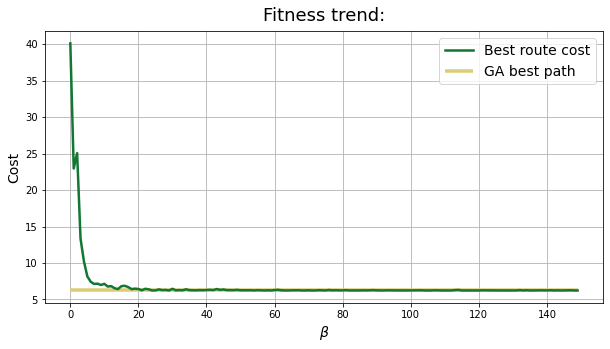

In [39]:
fit = np.loadtxt("cost.dat")

plt.figure(figsize=(10,5))
plt.title('Fitness trend:',fontsize=18,pad=10)
plt.plot(fit.T[0],fit.T[1], color='#117733', label='Best route cost',linewidth=2.5,alpha=1)
plt.hlines(6.2403,0,149,color='#DDCC77', label='GA best path',linewidth=3.5,alpha=1)
plt.grid(True)
plt.xlabel(r'$\beta$',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.show()

In questo grafico viene mostrato l'andamento della *fitness* del cammino migliore in funzione dell'inverso della temperatura ($\beta$). Notiamo che al crescere di $\beta$, la lunghezza del tragitto decresce molto repentinamente e converge al valore minimo ottenuto all'ultima generazione dell'algoritmo genetico.

**B) Percorso all'interno di un quadrato di lato 2**:

Generiamo all'interno di un quadrato di lato 2 (il cui centro è fissato nell'origine del piano) 32 città distribuite casualmente.

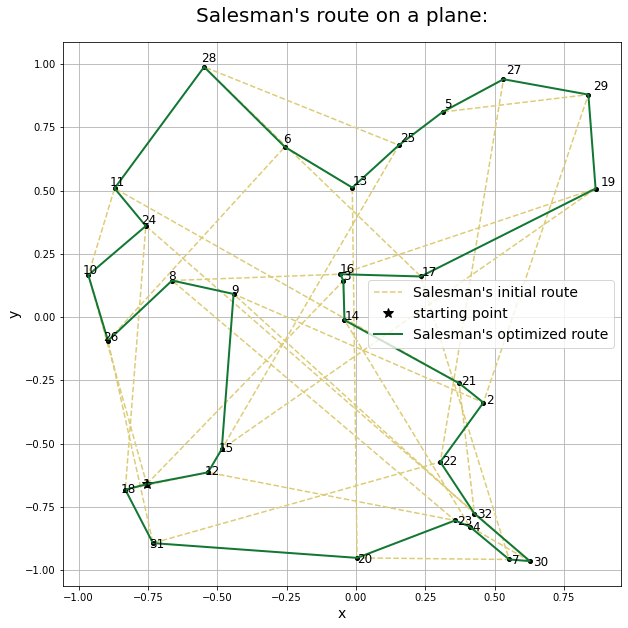

In [45]:
position1 = np.loadtxt('cities_positions1.dat')
position10 = np.loadtxt('cities_positions1_init.dat')
#position_ga = np.loadtxt('cities_positions_ga.dat')

plt.figure(figsize=(10,10))
plt.title("Salesman's route on a plane:", fontsize=20, pad=20)

#Initial route:
x10 = position10.T[0]
y10 = position10.T[1]
x10 = np.append(x10,x10[0])
y10 = np.append(y10,y10[0])
plt.plot(x10,y10,label="Salesman's initial route", color='#DDCC77',linestyle='--')

#Ga route:
#x_ga = position_ga.T[0]
#y_ga = position_ga.T[1]
#x_ga = np.append(x_ga,x_ga[0])
#y_ga = np.append(y_ga,y_ga[0])
#plt.plot(x_ga,y_ga,label="Salesman's optimized GA route", color='#CC6677',alpha=0.8)

#Final route:
x1 = position1.T[0]
y1 = position1.T[1]
label = position1.T[2]
for i in range(len(position1)):
    plt.plot(x1[i], y1[i], 'black',marker='.',markersize=8)
    plt.text(x1[i] * (1 + 0.02), y1[i] * (1 + 0.02) , int(label[i]) , fontsize=12)
plt.plot(x1[0],y1[0],'*', markersize=10, color='black',label='starting point') 
x1 = np.append(x1,x1[0])
y1 = np.append(y1,y1[0])
plt.plot(x1,y1,label="Salesman's optimized route", color='#117733',linewidth=2)

plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)
plt.show()

Come possiamo vedere, il percorso ottimale trovato mediante la tecnica del *Simulated Annealing* ci mostra come il cammino trovato nel caso dell'algoritmo genetico non sia la soluzione ottima al problema, bensì un minimo locale metastabile nello spazio delle configurazioni. Infatti osserviamo che:
* il valore di *fitness* per il cammino migliore nel caso del SA è: 9.273;
* il valore di *fitness* per il percorso migliore nel caso del GA è: 9.814.

Naturalmente la soluzione del GA è una buona soluzione al problema di interesse, ma nonostante ciò, non rappresenta il risultato ottimale.

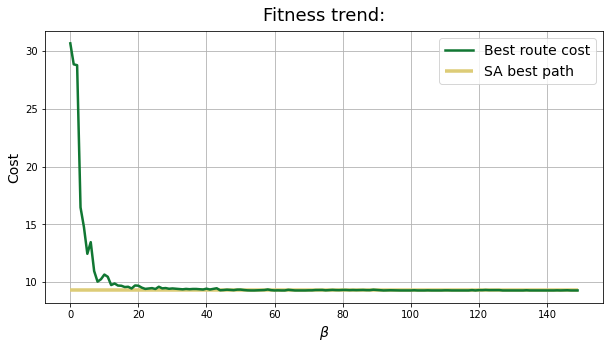

In [48]:
fit1 = np.loadtxt("cost1.dat")

#print(fit1[len(fit1)-1][1])

plt.figure(figsize=(10,5))
plt.title('Fitness trend:',fontsize=18,pad=10)
plt.plot(fit1.T[0],fit1.T[1], label='Best route cost',color='#117733',linewidth=2.5)
plt.hlines(9.27331,0,149,color='#DDCC77', label='SA best path',linewidth=3.5,alpha=1)
plt.grid(True)
plt.xlabel(r'$\beta$',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.show()

Come possiamo vedere dal grafico qui sopra, la convergenza al risultato finale da parte del *Simulated Annealing* è molto rapida e tende a stabilizzarsi intorno a $\beta=100$, oltre il quale non si osservano più fluttuazioni considerevoli. 
In base a questi risultati possiamo affermare che il *Simulated Annealing* da noi creato sembra essere un algoritmo più efficiente rispetto all'algoritmo genetico implementato nella precedente esercitazione .

### Esercizio 10.2

In questa seconda parte recuperiamo l'algoritmo genetico della precedente esercitazione e ne parallelizziamo il codice su 4 core.
Eseguiamo questa operazione ricorrendo alla libreria MPI, attraverso la quale, con un numero limitato di comandi,  siamo in grado di parallelizzare il codice seguendo il modello SIMD (Single Istruction Multiple Data).

L'algoritmo genetico viene fatto girare sui 4 core a disposizione e, periodicamente, dopo un certo numero di generazioni $N_{step\,per\, migrazione}$, i 4 processi indipendenti si scambiano in modo casuale il cromosoma migliore. Questo meccanismo arricchisce la procedura di ricerca della soluzione ottimale, in quanto favorisce lo spostamento di quei processi che tendono a stabilizzarsi in minimi locali metastabili. Vogliamo capire quindi se effettivamente questa procedura è in grado di portare a dei vantaggi e nel caso anche ad un risultato migliore.

Da un punto di vista computazionale, inizialmente i 4 processi devono agire sullo stesso set di città. In altre parole, ogni processo deve essere ugualmente inizializzato affinchè la procedura abbia un senso.
A tal fine il processo $P_1$ genera le condizioni iniziali e successivamente, grazie alla funzione `MPI_Bcast()`, vengono copiate le informazioni da $P_1$ a tutti gli altri processi $P_k$ con $k=2,3,4$.
Ogni $N_{step\,per\, migrazione}$, le funzioni `MPI_Send()` e `MPI_Recv()` agiranno in modo tale da trasmettere la sequenza delle etichette delle città casualmente da un processo all'altro. 
A ciascun processo viene poi richiesto di ricostruire internamente il cromosoma in base al vettore di interi ricevuto.

A questo punto avviamo la simulazione per $N_{cromosomi}=1000$, $N_{generazioni}=200$ e $N_{step\,per\, migrazione}=10$ generando, all'interno di un quadrato di lato 2, trentadue città distribuite casualmente. Vengono qui sotto presentati i risultati delle simulazioni processo per processo.

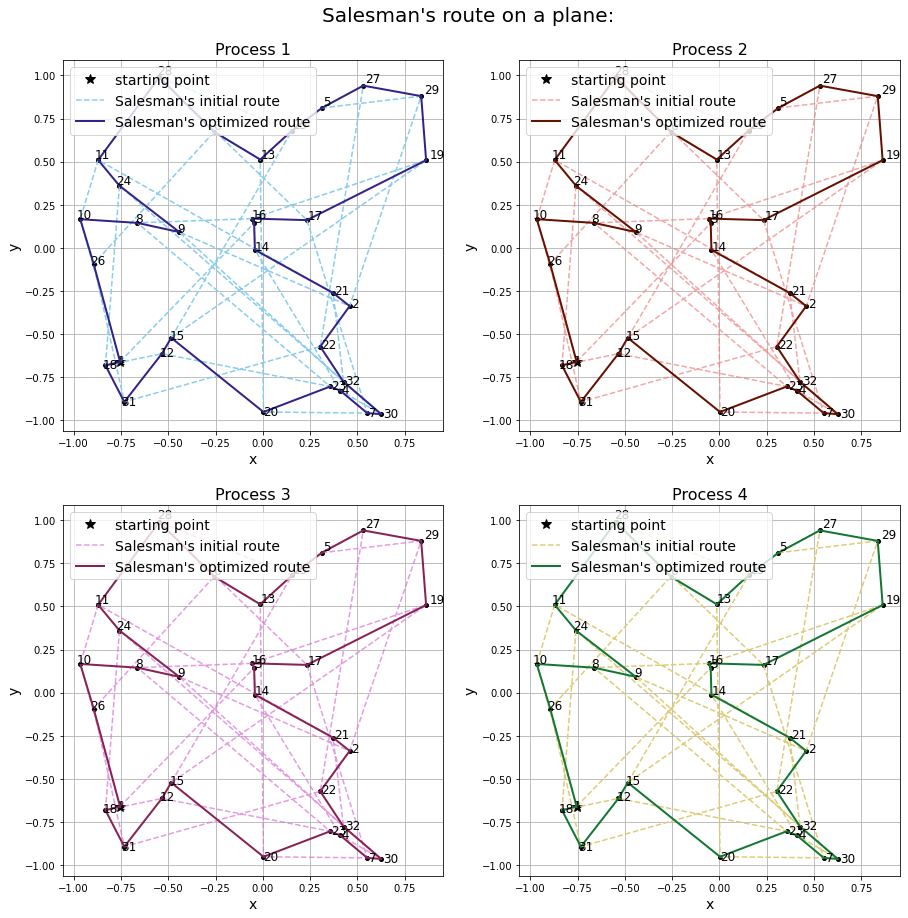

In [10]:
position00 = np.loadtxt('cities_positions1_init.dat')
position0 = np.loadtxt('cities_positions_0.dat')
position1 = np.loadtxt('cities_positions_1.dat')
position2 = np.loadtxt('cities_positions_2.dat')
position3 = np.loadtxt('cities_positions_3.dat')

plt.figure(figsize=(15,15))

#Initial route:
x00 = position00.T[0]
y00 = position00.T[1]
x00 = np.append(x00,x00[0])
y00 = np.append(y00,y00[0])

#Final route process1:
plt.subplot(2,2,1)
plt.title('Process 1',fontsize=16)
x0 = position0.T[0]
y0 = position0.T[1]
label = position0.T[2]
for i in range(len(position0)):
    plt.plot(x0[i], y0[i], 'black',marker='.',markersize=8)
    plt.text(x0[i] * (1 + 0.02), y0[i] * (1 + 0.02) , int(label[i]) , fontsize=12)
plt.plot(x0[0],y0[0],'*', markersize=10, color='black',label='starting point') 
x0 = np.append(x0,x0[0])
y0 = np.append(y0,y0[0])
plt.plot(x00,y00,label="Salesman's initial route", color='#88CCEE',linestyle='--')
plt.plot(x0,y0,label="Salesman's optimized route", color='#332288',linewidth=2)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)

#Final route process2:
plt.subplot(2,2,2)
plt.title('Process 2',fontsize=16)
x1 = position1.T[0]
y1 = position1.T[1]
label = position1.T[2]
for i in range(len(position1)):
    plt.plot(x1[i], y1[i], 'black',marker='.',markersize=8)
    plt.text(x1[i] * (1 + 0.02), y1[i] * (1 + 0.02) , int(label[i]) , fontsize=12)
plt.plot(x1[0],y1[0],'*', markersize=10, color='black',label='starting point') 
x1 = np.append(x1,x1[0])
y1 = np.append(y1,y1[0])
plt.plot(x00,y00,label="Salesman's initial route", color='lightcoral',linestyle='--',alpha=0.7)
plt.plot(x1,y1,label="Salesman's optimized route", color='#661100',linewidth=2)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)

#Final route process3:
plt.subplot(2,2,3)
plt.title('Process 3',fontsize=16)
x2 = position2.T[0]
y2 = position2.T[1]
label = position2.T[2]
for i in range(len(position2)):
    plt.plot(x2[i], y2[i], 'black',marker='.',markersize=8)
    plt.text(x2[i] * (1 + 0.02), y2[i] * (1 + 0.02) , int(label[i]) , fontsize=12)
plt.plot(x2[0],y2[0],'*', markersize=10, color='black',label='starting point') 
x2 = np.append(x2,x2[0])
y2 = np.append(y2,y2[0])
plt.plot(x00,y00,label="Salesman's initial route", color='orchid',linestyle='--',alpha=0.7)
plt.plot(x2,y2,label="Salesman's optimized route", color='#882255',linewidth=2)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)

#Final route process4:
plt.subplot(2,2,4)
plt.title('Process 4',fontsize=16)
x3 = position3.T[0]
y3 = position3.T[1]
label = position3.T[2]
for i in range(len(position3)):
    plt.plot(x3[i], y3[i], 'black',marker='.',markersize=8)
    plt.text(x3[i] * (1 + 0.02), y3[i] * (1 + 0.02) , int(label[i]) , fontsize=12)
plt.plot(x3[0],y3[0],'*', markersize=10, color='black',label='starting point') 
x3 = np.append(x3,x3[0])
y3 = np.append(y3,y3[0])
plt.plot(x00,y00,label="Salesman's initial route", color='#DDCC77',linestyle='--')
plt.plot(x3,y3,label="Salesman's optimized route", color='#117733',linewidth=2)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)

plt.suptitle("Salesman's route on a plane:", fontsize=20,y=0.93)
plt.show()

Dalle simulazioni possiamo osservare come i 4 processi arrivino esattamente alla stessa soluzione caratterizzata da *fitness* pari a 9.374. Tramite la parallelizzazione del codice, la soluzione finale è migliorata rispetto al caso di GA non parallelizzato. In base a questo risultato possiamo affermare che la parallelizzazione rende l'algoritmo genetico più efficiente, poiché ne arricchisce la procedura di ricerca della soluzione ottimale.
Nonostante questo miglioramento, possiamo notare come l'esito ottenuto non sia pienamente soddisfacente.
Infatti, mediante la tecnica del SA il risultato ottenuto ha *fitness* pari a 9.273, che è una soluzione migliore rispetto a quella ottenuta tramite parallelizzazione del GA.

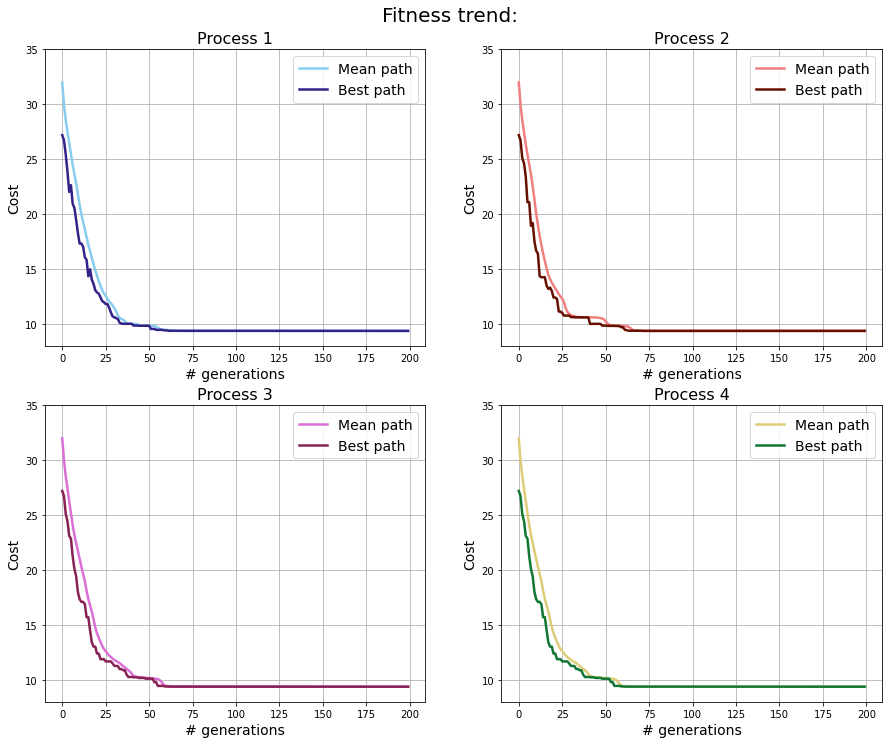

In [11]:
fit1 = np.loadtxt("best_cost0.dat")
cost1 = np.loadtxt("mean_cost0.dat")
fit2 = np.loadtxt("best_cost1.dat")
cost2 = np.loadtxt("mean_cost1.dat")
fit3 = np.loadtxt("best_cost2.dat")
cost3 = np.loadtxt("mean_cost2.dat")
fit4 = np.loadtxt("best_cost3.dat")
cost4 = np.loadtxt("mean_cost3.dat")

#print(fit1.T[1][99])

plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.title('Process 1',fontsize=16)
plt.plot(cost1.T[0],cost1.T[1], label='Mean path',linewidth=2.5,color='#88CCEE')
plt.plot(fit1.T[0],fit1.T[1], label='Best path',linewidth=2.5,color='#332288')
plt.xlabel('# generations',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)
plt.ylim(8,35)

plt.subplot(2,2,2)
plt.title('Process 2',fontsize=16)
plt.plot(cost2.T[0],cost2.T[1], label='Mean path',linewidth=2.5,color='lightcoral')
plt.plot(fit2.T[0],fit2.T[1], label='Best path',linewidth=2.5,color='#661100')
plt.xlabel('# generations',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)
plt.ylim(8,35)

plt.subplot(2,2,3)
plt.title('Process 3',fontsize=16)
plt.plot(cost3.T[0],cost3.T[1], label='Mean path',linewidth=2.5,color='orchid')
plt.plot(fit3.T[0],fit3.T[1], label='Best path',linewidth=2.5,color='#882255')
plt.xlabel('# generations',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)
plt.ylim(8,35)

plt.subplot(2,2,4)
plt.title('Process 4',fontsize=16)
plt.plot(cost4.T[0],cost4.T[1], label='Mean path',linewidth=2.5,color='#DDCC77')
plt.plot(fit4.T[0],fit4.T[1], label='Best path',linewidth=2.5,color='#117733')
plt.xlabel('# generations',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)
plt.ylim(8,35)

plt.suptitle('Fitness trend:',fontsize=20,y=0.93)
plt.show()

Osserviamo dai grafici sovrastanti che l'andamento dettagliato della miglior *fitness* al crescere delle generazioni è differente per ogni processo e questo certifica il fatto che le mosse effettuare su ciascun core siano davvero indipendenti.
Per quanto riguarda la media delle *fitness*, l'andamento è pressochè uguale per tutti i processi. Ciò non deve sorprenderci, poiché una migrazione da un processo all'altro può essere intesa come una mutazione che avviene nel passaggio da una generazione a quella successiva. Per questo motivo l'influenza di un singolo cromosoma sostituto (magari con *fitness* non troppo distante da quello precedente) sul totale della popolazione ha un peso statistico poco rilevante. 
Notiamo infine che la convergenza, rispetto al caso di GA non parallelizzato è migliorata. Infatti tutti e 4 i processi individuano la soluzione "ottima" prima delle 75 generazioni, e non in 120 come nel caso di GA non parallelizzato.